In [1]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

In [2]:
batch_size = 8
evaluate = False
backbone = 'mobilenet_v2'

hyper_params = train_utils.get_hyper_params(backbone)

In [3]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [300, 300, 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label']
                  }}

    return output_dict

def get_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    size_info = dataset.reduce(0, lambda x, _ : x + 1).numpy()
    return dataset, size_info

In [4]:
test_data, size_info = get_dataset(r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord")
total_items = size_info

In [5]:
labels = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

In [6]:
data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [7]:
ssd_model = get_model(hyper_params)
ssd_model_path = io_utils.get_model_path(backbone)
ssd_model.load_weights("./trained/ssd_mobilenet_v2_model_weights_150 epoch 1e-4 and 64 batch size (stucked) in 149 epoch.h5")
prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

In [8]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)

261/261 [==============================] - 134s 509ms/step


In [9]:
test_data, size_info = get_dataset(r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord")
test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [10]:
def IOU_score(pred_bbox, gt_bbox, width = 300, height = 300):
    p_y1, p_x1, p_y2, p_x2 = pred_bbox
    gt_y1, gt_x1, gt_y2, gt_x2 = gt_bbox

    p_y1, p_x1, p_y2, p_x2 = int(p_y1 * height), int(p_x1 * width), int(p_y2 * height), int(p_x2 * width)
    gt_y1, gt_x1, gt_y2, gt_x2 = int(gt_y1 * height), int(gt_x1 * width), int(gt_y2 * height), int(gt_x2 * width)
    
    area_pbox = (p_x2 - p_x1) * (p_y2 - p_y1)
    area_gtbox = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    xx = max(p_x1, gt_x1)
    yy = max(p_y1, gt_y1)
    aa = min(p_x2, gt_x2)
    bb = min(p_y2, gt_y2)

    w = max(0, aa - xx)
    h = max(0, bb - yy)

    intersection_area = w * h

    if intersection_area == 0:
        return 0
    union_area = area_pbox + area_gtbox - intersection_area
    return float(intersection_area) / float(union_area)

In [11]:
gt_ROIs = 0
image_no = 0
iou_threshold = 0.5
data_list = []
for index, ele in enumerate(test_data):
    gt_ind_ROI = 0
    image_name = 'Image' + str(image_no)
    bounding_boxes = ele[1].numpy()
    class_labels = ele[2].numpy()
    
    predicted_pred_bboxes = pred_bboxes[index]
    pred_class_labels = pred_labels[index]
    pred_conf_scores = pred_scores[index]
    
    for _ in class_labels:
        gt_ind_ROI += 1
    gt_ROIs += gt_ind_ROI  
    
    detected_count = 0
    for bbox in predicted_pred_bboxes:
        if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
            detected_count += 1
        else:
            break
    
    # Caculating TP, FP, TN
    
#     for i in range(detected_count):
#         tp = 0
#         fp = 0
#         tn = 0
        
#         # calculating TP and FP
#         if pred_class_labels[i] in class_labels:
#             class_label_index = class_labels.tolist().index(pred_class_labels[i])
#             if IOU_score(predicted_pred_bboxes[i], bounding_boxes[class_label_index]) > iou_threshold:
#                 tp = 1
#             else:
#                 fp = 1 
#         else:
#             fp = 1

    for i in range(detected_count):
        tp = 0
        fp = 0
        tn = 0
        
        for j, bbox in enumerate(bounding_boxes):
            if IOU_score(predicted_pred_bboxes[i], bbox) > 0.5:
                if pred_class_labels[i] == class_labels[j]:
                    tp = 1
                else:
                    fp = 1
                break
         
            
        # Calculate TN
        for j in range(detected_count):
            if j != i:
#                 if pred_class_labels[j] in class_labels:
#                     class_label_index = class_labels.tolist().index(pred_class_labels[j])
#                     if IOU_score(predicted_pred_bboxes[j], bounding_boxes[class_label_index]) > iou_threshold:
#                         tn += 1
                for k, bbox_ in enumerate(bounding_boxes):
                    if IOU_score(predicted_pred_bboxes[j], bbox_) > iou_threshold:
                        tn += 1
        data_list.append((image_name, labels[int(pred_class_labels[i])], pred_conf_scores[i] * 100, tp, fp, tn))
    
    image_no += 1

column_name = ['Image', 'Detection', 'Confidence', 'TP', 'FP', 'TN']    
df = pd.DataFrame(data_list, columns = column_name)
df.sort_values(['Confidence'], inplace = True, ignore_index = True, ascending = False)
df.head(20)

new_data_list = list()
accumulated_TP = 0
accumulated_FP = 0
accumulated_TN = 0

for row in df.iterrows():
    accumulated_TP += row[1]['TP']
    accumulated_FP += row[1]['FP']
    accumulated_TN += row[1]['TN']
    
    recall = float(accumulated_TP) / gt_ROIs
    try:
        specificity = float(accumulated_TN) / (float(accumulated_TN) + float(accumulated_FP))
    except ZeroDivisionError:
        specificity = 0.0
    FPR = 1 - specificity
    
    if FPR < 0.09:
        new_data_list.append((row[1]['Image'], row[1]['Detection'], row[1]['Confidence'], row[1]['TP'], row[1]['FP'], row[1]['TN'], accumulated_TP, accumulated_FP, accumulated_TN, recall, specificity, FPR))

column_name = ['Image', 'Detection', 'Confidence', "TP", "FP", 'TN', 'Acc TP', 'Acc FP', 'Acc TN', 'Recall', 'Specificity', 'FPR']
new_df = pd.DataFrame(new_data_list, columns = column_name)


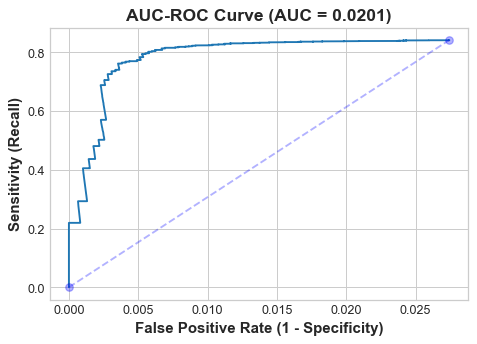

In [41]:
plt.style.use('seaborn-whitegrid')
font_title = {'size': 14, 'weight' : 'bold'}
font_label = {'size': 12, 'weight' : 'bold'}
plt.figure(figsize = (6, 4), dpi = 90)

fpr = new_df['FPR'].tolist()
recall = new_df['Recall'].tolist()
len_fpr = len(fpr)
len_recall = len(recall)

auc_value = calculate_auc(new_df['FPR'], new_df['Recall'])

plt.plot(fpr, recall)
plt.title("AUC-ROC Curve (AUC = %.4f)" % auc_value, fontdict = font_title )
plt.xlabel('False Positive Rate (1 - Specificity)', fontdict = font_label)
plt.ylabel('Sensitivity (Recall)', fontdict = font_label)
x_values = [fpr[0], fpr[len_fpr - 1]]
y_values = [recall[0], recall[len_recall - 1]]
plt.plot(x_values, y_values, 'bo', linestyle = '--', alpha = 0.30)
save_loc = r"./Curves and Graphs/AUC-ROC Curve.jpg"
plt.savefig(save_loc, dpi = 160, bbox_inches = 'tight', pad_inches = 0.3)
plt.show()

In [40]:
def calculate_auc(fpr, recall):
    from sklearn.metrics import auc

    compare_list = np.arange(0.00, 0.20, 0.0022).tolist()

    curr_ind = 0
    recall_list = list()
    fpr_list = list()

    for ind, fpr in enumerate(fpr):
        if fpr >= compare_list[curr_ind]:
            fpr_list.append(fpr)
            recall_list.append(recall.tolist()[ind])
            curr_ind += 1
    return auc(fpr_list, recall_list)
#     plt.figure(figsize = (8, 6), dpi = 90)
#     plt.plot(fpr_list, recall_list)

#     plt.title("Approximated AUC-ROC Curve (for AUC calculation)")
#     plt.xlabel('False Positive Rate (1 - Specificity)')
#     plt.ylabel('Sensitivity (Recall)')
#     plt.show()

In [11]:
class_len = len(labels)
cm_matrix = np.zeros(shape = (class_len, class_len))

In [14]:
for index, ele in enumerate(test_data):
    bounding_boxes = ele[1].numpy()
    class_labels = ele[2].numpy()

    predicted_pred_bboxes = pred_bboxes[index]
    pred_class_labels = pred_labels[index]
    pred_conf_scores = pred_scores[index]
    
    detected_count = 0
    for bbox in predicted_pred_bboxes:
        if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
            detected_count += 1
        else:
            break
            
    for i in range(detected_count):
        for j, bbox in enumerate(bounding_boxes):
            if IOU_score(predicted_pred_bboxes[i], bbox) > 0.5:
                cm_matrix[int(pred_class_labels[i])][int(class_labels[j])] += 1.0
                break
            else:
                cm_matrix[int(pred_class_labels[i])][int(class_labels[j])] += 1.0
print(cm_matrix)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0. 130.   0. ...   0.   0.   0.]
 [  0.   0. 190. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 244.   0.   0.]
 [  0.   0.   0. ...   0. 176.   0.]
 [  0.   0.   0. ...   0.   0. 168.]]


In [16]:
max_value = cm_matrix.max()
cm_matrix = cm_matrix / max_value

In [22]:
cm_matrix = np.around(cm_matrix, 1)

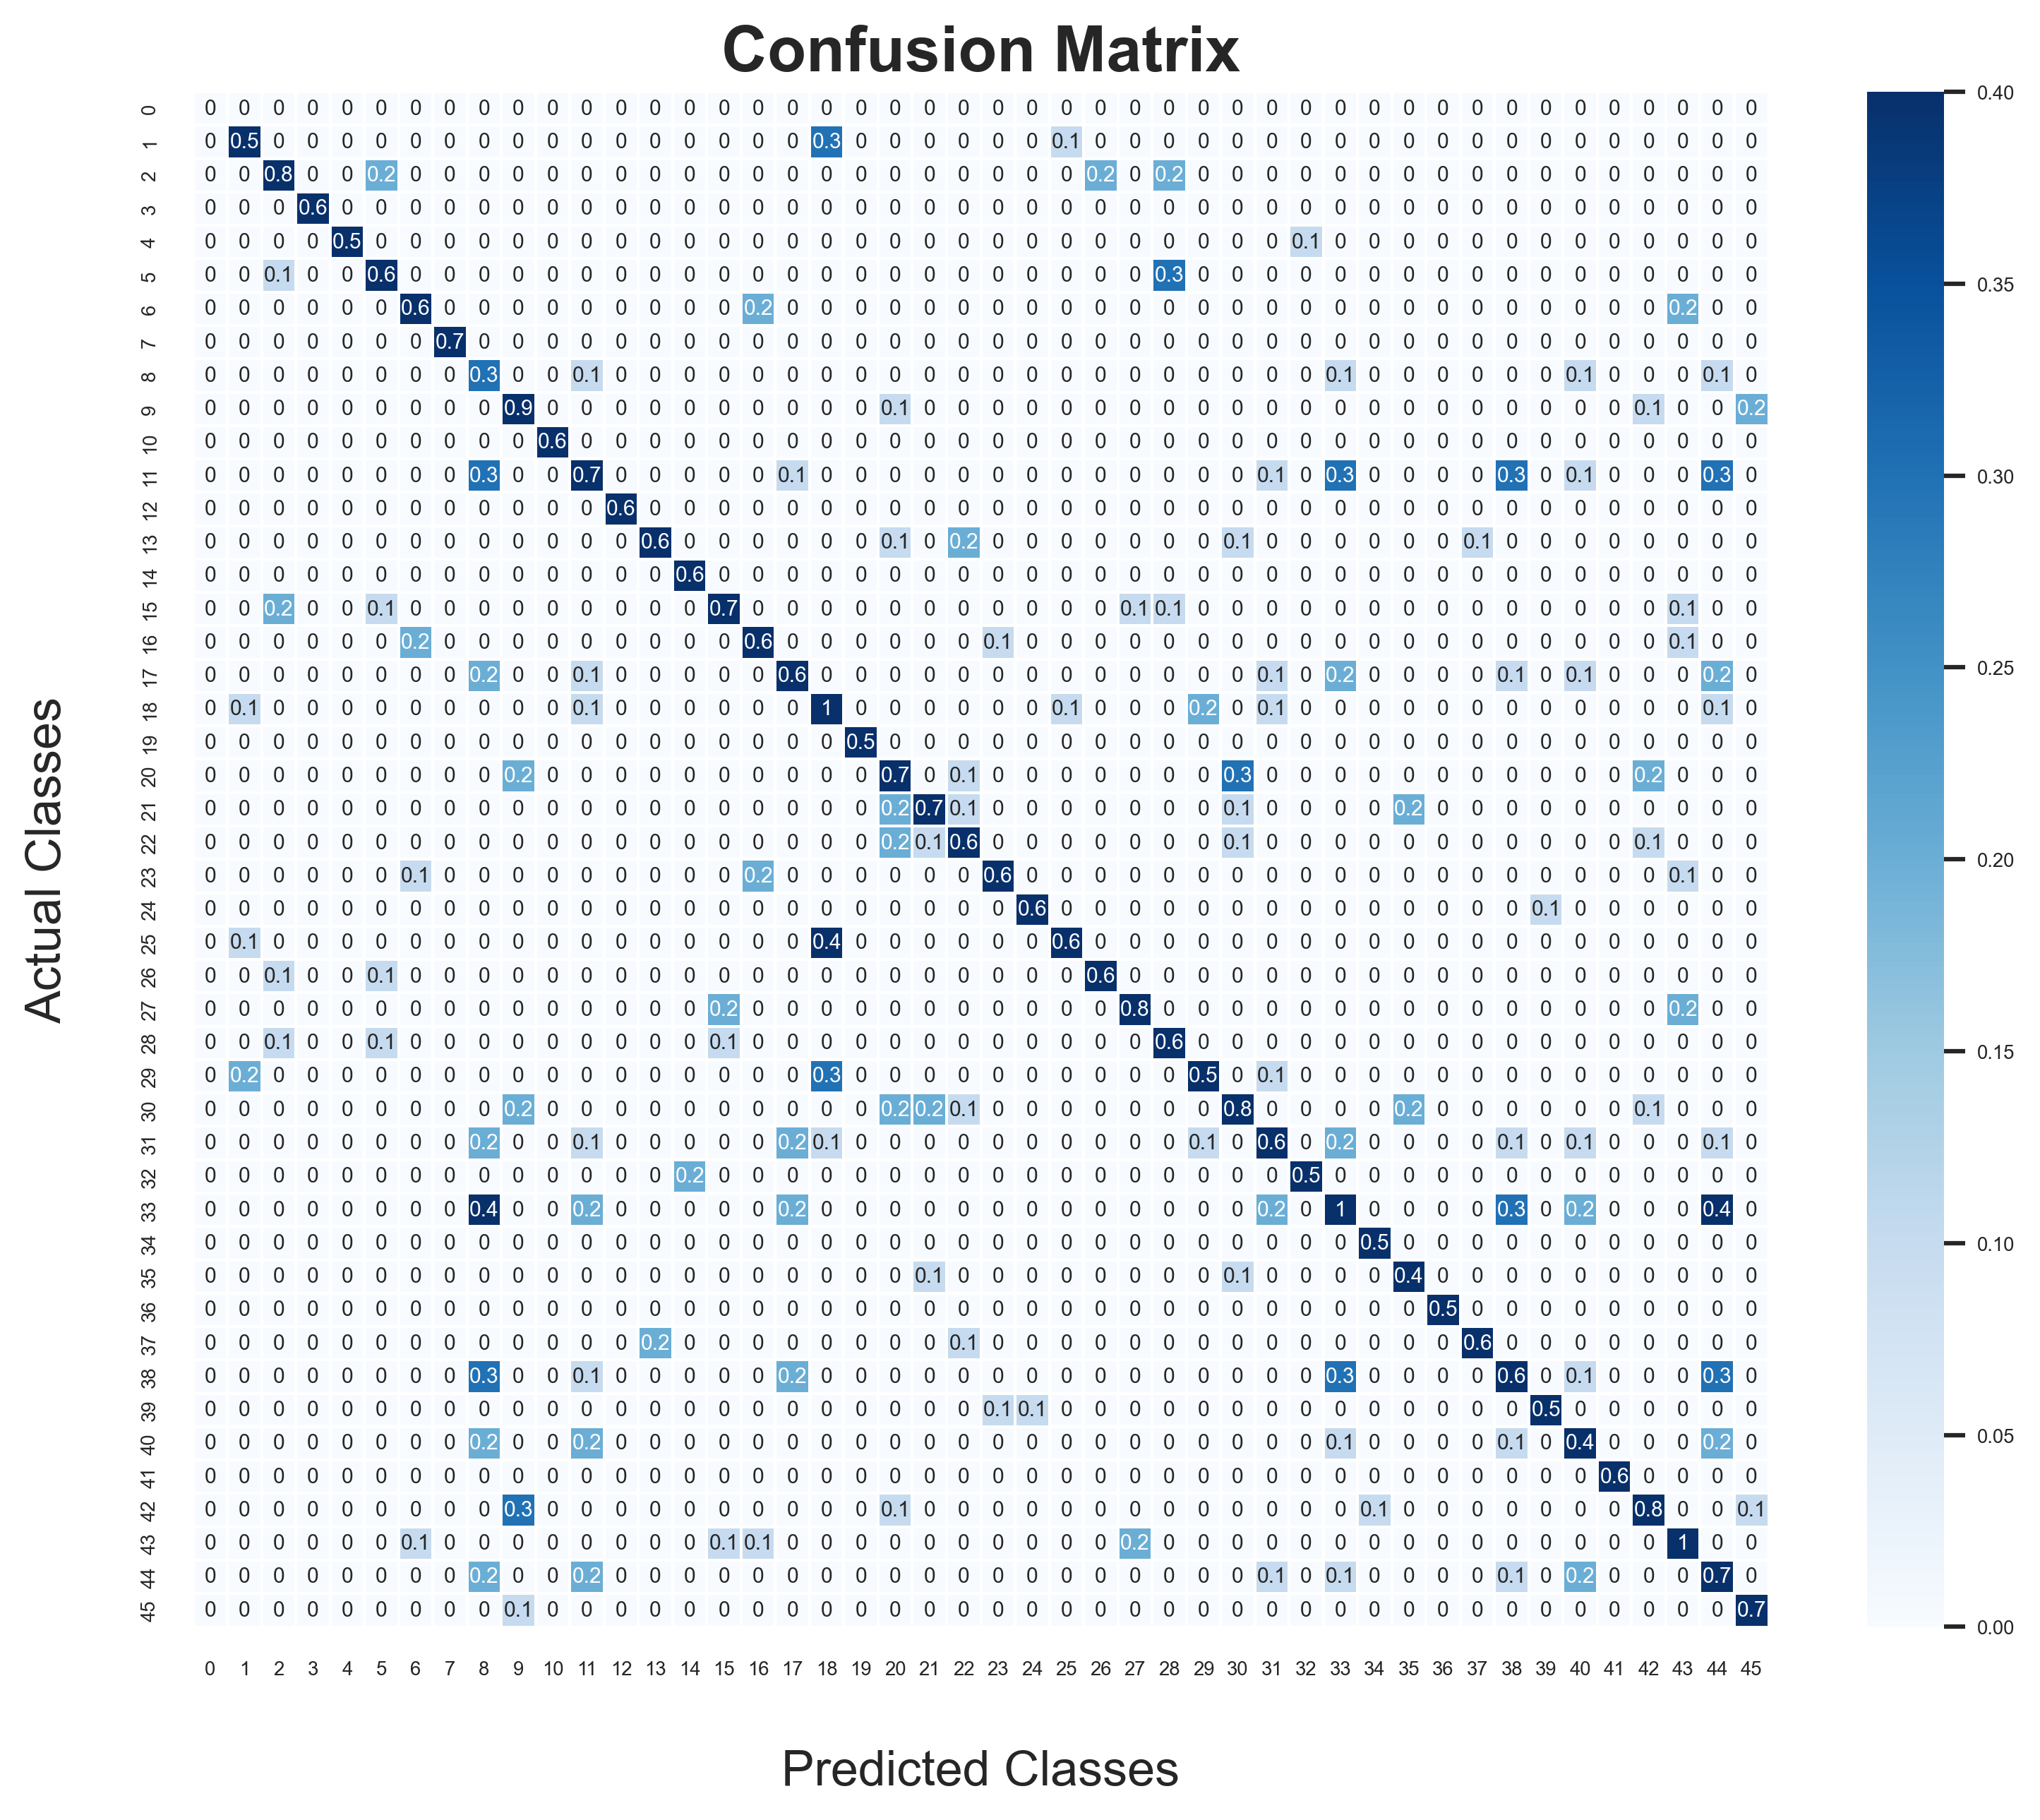

In [23]:
import seaborn as sns
plt.figure(figsize = (10, 8), dpi = 360)
sns.set(font_scale = 0.5)

font_title = {'size': 18, 'weight': 'bold'}

ax = sns.heatmap(cm_matrix, cmap = 'Blues', annot=True, cbar = True, robust = True, linewidths = 0.8)
plt.title("Confusion Matrix", fontdict = font_title)
ax.set_xlabel("Predicted Classes", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

ax.set_ylabel("Actual Classes", fontsize=14, labelpad=20)

save_loc = r"./Curves and Graphs/Confusion Matrix.jpg"
plt.savefig(save_loc, dpi = 360, bbox_inches = 'tight', pad_inches = 0.3)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()